# 01_snow_intro.ipynb
This notebook will introduce you to the relevant datasets and python packages for this project

In [28]:
import pandas as pd
import geopandas as gpd # similar to pandas but for spatial data
import xarray as xr # package for handling spatial data in high dimensions
import rioxarray as rxr # package for handling spatial data in high dimensions
import matplotlib.pyplot as plt
import numpy as np
import os
import rioxarray as rxr

# Overview
We will be using example data from the San Joaquin basin, which is abbreviated ***USCASJ*** throughout the naming convention of my datasets.

# Datasets

## shapes
This is spatial data representing points and polygons. While these can be represented by the xarray packages, it is often simplest to represent those using geopandas.
* Examples
    * point: location of the SNOTEL or CDEC weather stations.
    * polygon: extent of the our basin.
* Coordinates
    * Geographic: Latitude/Longitude -- thus is dependent on the datum you use.
    * Projected: Ex projected UTM coordinates in meters. (Used for area or distance calculations).
    * Here is some more information on the difference https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/coordinate-systems-difference/
    * For this project will use ***EPSG:4326*** for geographic and ***EPSG:32611*** for projected (at least in California)

### San Joaquin Basin Boundary

In [5]:
# read in San Joaquin shapefile.
sj_gdf = gpd.read_file('../data/shape/USCASJ/USCASJ.shp')
sj_gdf

,AreaAcres,AreaSqKm,States,HUC8,Name,hru_id,geometry
0,1048826.0,4244.45,CA,18040006,Upper San Joaquin,18040006,"POLYGON ((-119.18358 37.73922, -119.1835 37.73..."


In [6]:
# look at shapefiles default projection.
sj_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

we can see that its default coordinate system is EPSG:4326 which is what we want!

#### Plotting

<Axes: >

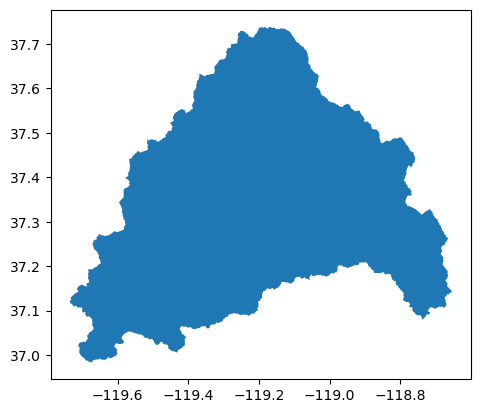

In [7]:
sj_gdf.plot()

ok lets get some reference of where this is located and pull in state boundaries

In [9]:
states_gdf = gpd.read_file('../data/shape/states/cb_2018_us_state_20m.shp')
states_gdf.head(5)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77926, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.7222, -75.75323 39.7579..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [10]:
states_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

***Important:*** as we can see the coordinate system for the states shapefile is **EPSG:4269** while our basin polygon is **EPSG:4326**. These are mismatching and will not align. Therefore we are going to reproject the states shape to EPSG:4326.

In [11]:
# reproject states
states_gdf = states_gdf.to_crs('EPSG:4326')
states_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

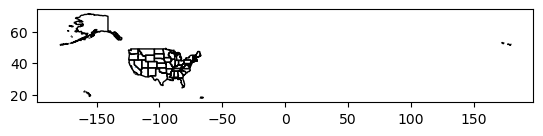

In [12]:
fig,ax = plt.subplots()
states_gdf.plot(ax=ax,color = 'none',edgecolor = 'black')
sj_gdf.plot(ax=ax)

<Axes: >

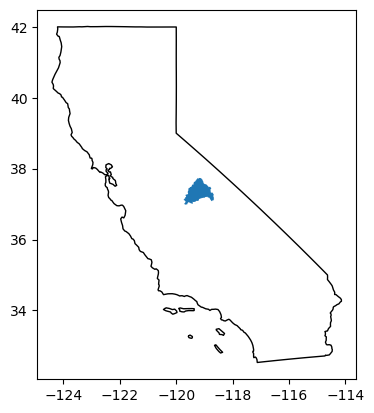

In [13]:
# lets query the states to just plot california
fig,ax = plt.subplots()
states_gdf[states_gdf['STUSPS'] == 'CA'].plot(ax=ax,color = 'none',edgecolor = 'black')
sj_gdf.plot(ax=ax)

<Axes: >

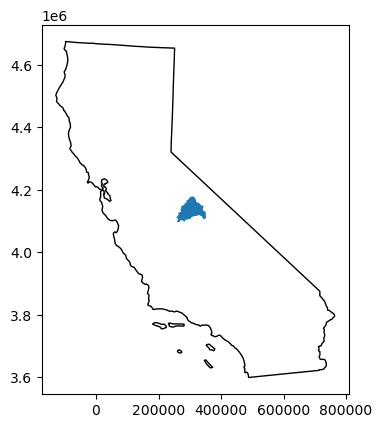

In [14]:
# lets project both into utm coordinates and plot.
states_proj = states_gdf.to_crs('EPSG:32611')
sj_proj = sj_gdf.to_crs('EPSG:32611')
# plotting.
fig,ax = plt.subplots()
states_proj[states_proj['STUSPS'] == 'CA'].plot(ax=ax,color = 'none',edgecolor = 'black')
sj_proj.plot(ax=ax)

#### Why does geographic vs projected matter?
The distance between degrees of longitude and latitude change depending on where you are in the globe. Therefore, geographic is fine for location but not good for aggregation.

In [15]:
print(f'area of geographic coordinates: {sj_gdf.area.values[0]} degrees squared (what does that mean??)')
print(f'area of projected coordinates: {sj_proj.area.values[0]} meters squared')

area of geographic coordinates: 0.4315669019085175 degrees squared (what does that mean??)
area of projected coordinates: 4245121920.7178807 meters squared


/var/folders/np/7hwxwvkn4z1bw5qfbx0_1l7m00130x/T/ipykernel_55633/760880502.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f'area of geographic coordinates: {sj_gdf.area.values[0]} degrees squared (what does that mean??)')


### Insitu Point Locations

In [17]:
insitu_gdf = gpd.read_file('../data/insitu/USCASJ/obs_summary.shp')
insitu_gdf.head(5)

,name,id,network,elevation_,latitude,longitude,matching_f,median_ele,median_cou,missing_fl,corr_elev_,pil_elev_f,corr_ele_1,geometry
0,AGNEW PASS,AGP,cdec,2880.36,37.726631,-119.141731,5,NaN,0,26,NaN,9450.000302,NaN,POINT (-119.14173 37.72663)
1,BLACKCAP BASIN,BCB,cdec,3139.44,37.066685,-118.773010,19,11090.751953,79838,12,11693.317383,10300.000330,10168.405273,POINT (-118.77301 37.06668)
2,BIG PINE CREEK,BGP,cdec,2987.04,37.127815,-118.476967,25,8706.939453,257333,6,9616.681641,9800.000314,7941.031250,POINT (-118.47697 37.12782)
3,BISHOP PASS,BSH,cdec,3413.76,37.100000,-118.557000,16,8271.562500,26437,15,9020.522461,11200.000358,7731.993164,POINT (-118.557 37.1)
4,CHILKOOT MEADOW,CHM,cdec,2179.32,37.408390,-119.492188,28,8423.398438,152861,3,9332.275391,7150.000229,7633.132812,POINT (-119.49219 37.40839)


#### Projecting

In [18]:
insitu_gdf.crs

In [19]:
# for some reason there isn't a coordinate system with this shapefile so lets set it.
insitu_gdf = insitu_gdf.set_crs('EPSG:4326')
# create a projected geodataframe.
insitu_proj = insitu_gdf.to_crs('EPSG:32611')

#### Plotting

<Axes: >

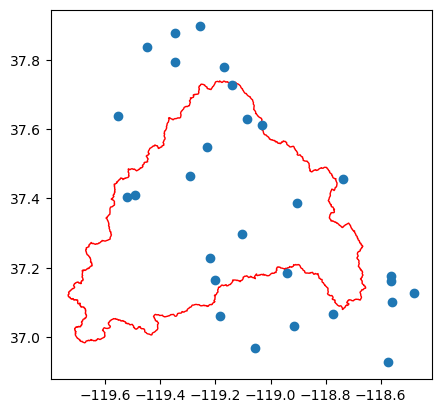

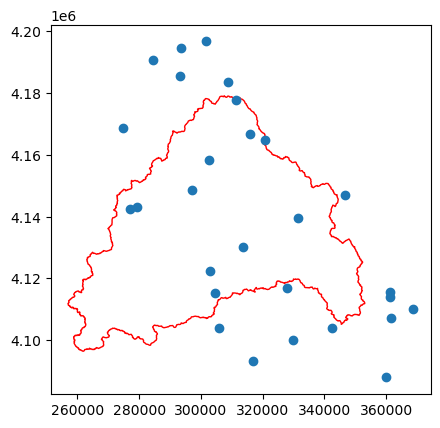

In [20]:

# geographic plotting.
fig,ax = plt.subplots()
sj_gdf.plot(ax=ax,color = 'none',edgecolor = 'red')
insitu_gdf.plot(ax=ax)

# projected plotting.
fig,ax = plt.subplots()
sj_proj.plot(ax=ax,color = 'none',edgecolor = 'red')
insitu_proj.plot(ax=ax)

## insitu timeseries
The weather station data comes from SNOTEL and CDEC weather stations. I am happy to explain the difference some other time. Essentially SNOTEL is federal and CDEC is specific to the state of California. Unfortunately CDEC has worse QA protocal therefore there are many data quality issues. I combine these two datasources.


CDEC: https://cdec.water.ca.gov/snowapp/sweq.action

SNOTEL: https://www.nrcs.usda.gov/resources/data-and-reports/snow-and-water-interactive-map

### one snow pillow

In [16]:
# here we can look at loading the raw downloaded pillow data for Tuolume Meadows (TUM)
tum_raw = xr.load_dataset('data/insitu/USCASJ/TUM.nc')
# here we can look at loading the QA'd pillow data for Tuolume Meadows (TUM)
tum_qa = xr.load_dataset('data/insitu/USCASJ/qa/TUM.nc')

In [17]:
tum_raw

<xarray.Dataset> Size: 72kB
Dimensions:  (time: 4497)
Coordinates:
  * time     (time) datetime64[ns] 36kB 2012-10-01 2012-10-02 ... 2025-01-22
Data variables:
    TUM      (time) float64 36kB 0.0 0.0 0.0 0.0 0.0 ... 153.4 154.4 148.3 146.8

again xarray was written based on pandas so alot of its functionality is similar. 
***xarray documentation:*** https://docs.xarray.dev/en/stable/

Text(0, 0.5, 'SWE [mm]')

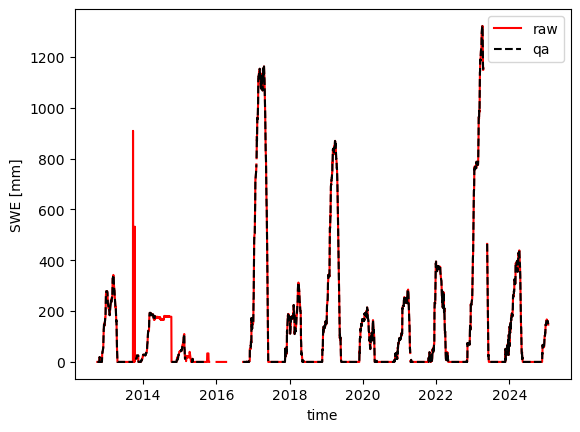

In [18]:
fig,ax = plt.subplots()
tum_raw['TUM'].plot(ax=ax,color = 'red',label = 'raw')
tum_qa['TUM'].plot(ax=ax,color = 'black',linestyle = '--',label = 'qa')
plt.legend()
plt.ylabel('SWE [mm]')

***NOTE:*** Hydrologists' calendar is defined as **water year** which is October 1st through September 30th. Therefore water year 2014 would be October 1st, 2013 through September 30th, 2014.

Lets select data for the 2014 water year.

In [19]:
tum_raw.sel(time=slice(np.datetime64('2013-10-01'),np.datetime64('2014-09-30')))

<xarray.Dataset> Size: 6kB
Dimensions:  (time: 365)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2013-10-01 2013-10-02 ... 2014-09-30
Data variables:
    TUM      (time) float64 3kB 531.4 531.4 531.4 528.3 ... 177.8 177.8 177.8

Text(0, 0.5, 'SWE [mm]')

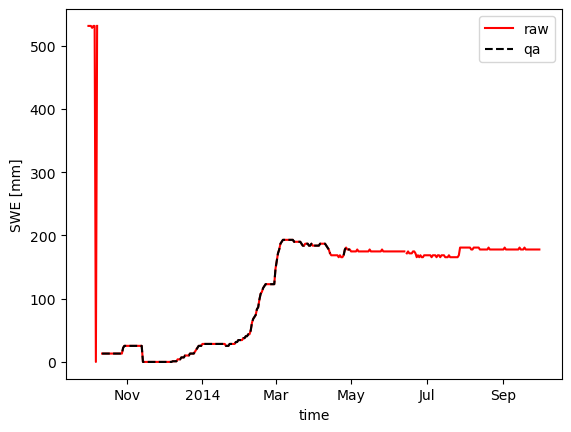

In [20]:
fig,ax = plt.subplots()
tum_raw.sel(time=slice(np.datetime64('2013-10-01'),np.datetime64('2014-09-30')))['TUM'].plot(ax=ax,color = 'red',label = 'raw')
tum_qa.sel(time=slice(np.datetime64('2013-10-01'),np.datetime64('2014-09-30')))['TUM'].plot(ax=ax,color = 'black',linestyle = '--',label = 'qa')
plt.legend()
plt.ylabel('SWE [mm]')

### all pillows

In [21]:
# here we can look at loading the raw downloaded pillow data for Tuolume Meadows (TUM)
tum_raw = xr.load_dataset('data/insitu/USCASJ/TUM.nc')
# here we can look at loading the QA'd pillow data for Tuolume Meadows (TUM)
tum_qa = xr.load_dataset('data/insitu/USCASJ/qa/TUM.nc')

In [22]:
raw_dir = 'data/insitu/USCASJ/'
raw_pills = xr.concat([xr.load_dataset(f'{raw_dir}{i}') for i in os.listdir(raw_dir) if '.nc' in i],dim = 'time')

qa_dir = 'data/insitu/USCASJ/qa/'
qa_pills = xr.concat([xr.load_dataset(f'{qa_dir}{i}') for i in os.listdir(qa_dir) if '.nc' in i],dim = 'time')

In [23]:
raw_pills

<xarray.Dataset> Size: 36MB
Dimensions:  (time: 139407)
Coordinates:
  * time     (time) datetime64[ns] 1MB 2012-10-01 2012-10-02 ... 2025-01-22
Data variables: (12/31)
    DAN      (time) float64 1MB 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    VLC      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    TUM      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    KUP      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    MAM      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    BCB      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    ...       ...
    CHM      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    UBC      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    LLE      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    GRV      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    AGP      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    GRM      (time) float64 1MB nan nan nan nan nan ... 171.4 164.8 174.8 163.1

In [24]:
qa_pills

<xarray.Dataset> Size: 36MB
Dimensions:  (time: 139407)
Coordinates:
  * time     (time) datetime64[ns] 1MB 2012-10-01 2012-10-02 ... 2025-01-22
Data variables: (12/31)
    DAN      (time) float64 1MB 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    VLC      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    TUM      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    KUP      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    MAM      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    BCB      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    ...       ...
    CHM      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    UBC      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    LLE      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    GRV      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    AGP      (time) float64 1MB nan nan nan nan nan nan ... nan nan nan nan nan
    GRM      (time) float64 1MB nan nan nan nan nan ... 171.4 164.8 174.8 163.1

Text(0.5, 1.0, 'all raw pils')

/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


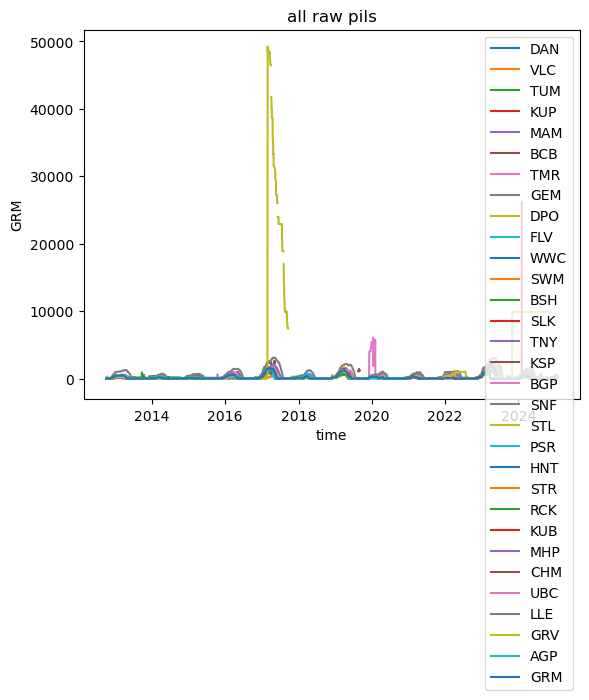

In [25]:
fig,ax = plt.subplots()
for pil in list(raw_pills.keys()):
    raw_pills[pil].plot(ax=ax,label = pil)
plt.legend()
plt.title('all raw pils')

Text(0.5, 1.0, 'qa pils')

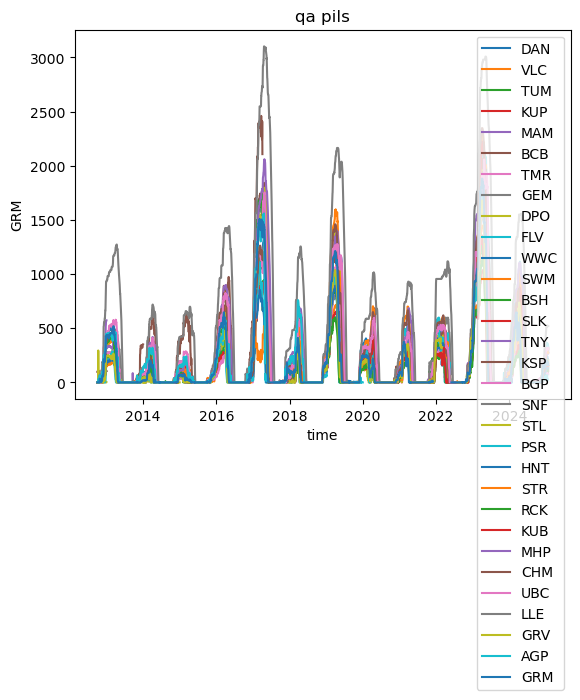

In [26]:
fig,ax = plt.subplots()
for pil in list(qa_pills.keys()):
    qa_pills[pil].plot(ax=ax,label = pil)
plt.legend()
plt.title('qa pils')

## aso flights
The ASO flights originated as a NASA funding program from 2013-2019 and can be downloaded from NSIDC. Starting in 2020 ASO was developed into a private company and now can be downloaded from the ASO website.

Here I have already downloaded and processed the ASO 50M SWE data for the San Joaquin so that the grids and projections align.

NSIDC: https://nsidc.org/data/aso

ASO: https://www.airbornesnowobservatories.com/

### example load in one flight using rioxarray

In [41]:
da1 = rxr.open_rasterio('../data/aso/USCASJ/ASO_50M_SWE_USCASJ_20170129.tif').squeeze().drop('band')
da1

/var/folders/np/7hwxwvkn4z1bw5qfbx0_1l7m00130x/T/ipykernel_55633/2823129261.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da1 = rxr.open_rasterio('../data/aso/USCASJ/ASO_50M_SWE_USCASJ_20170129.tif').squeeze().drop('band')


<xarray.DataArray (y: 1875, x: 2063)> Size: 15MB
[3868125 values with dtype=float32]
Coordinates:
  * x            (x) float64 17kB 2.594e+05 2.595e+05 ... 3.625e+05 3.625e+05
  * y            (y) float64 15kB 4.188e+06 4.188e+06 ... 4.094e+06 4.094e+06
    spatial_ref  int64 8B 0
Attributes:
    Band_1:         ASO SUPER Snow Water Equivalent [m]
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ASO SUPER Snow Water Equivalent [m]

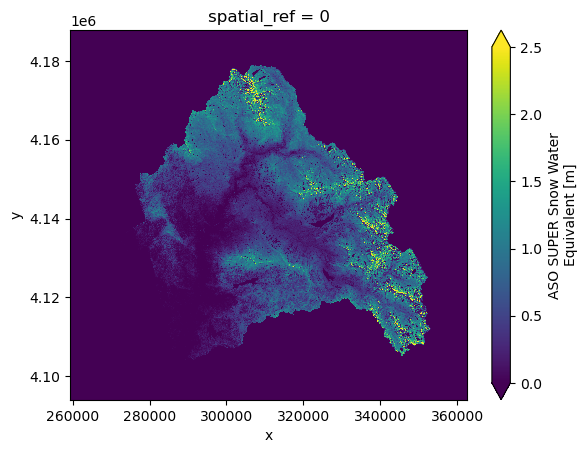

In [40]:
da1.plot(vmin = 0,vmax = 2.5)

### Example loading in all (concatenated flights) using xarray.
***NOTE:*** you will need to download the aso_spatial zipped file for the google drive and extract it to ../data/aso/USCASJ/aso_spatial.nc. The file is too big for github.

In [42]:
# spatial aso data.
aso_data_1 = xr.load_dataset(f'../data/aso/USCASJ/aso_spatial.nc')

In [43]:
aso_data_1

<xarray.Dataset> Size: 724MB
Dimensions:      (date: 31, x: 1803, y: 1620)
Coordinates:
  * date         (date) datetime64[ns] 248B 2017-01-29 2017-03-09 ... 2024-06-29
  * x            (x) float64 14kB 2.629e+05 2.629e+05 ... 3.529e+05 3.53e+05
  * y            (y) float64 13kB 4.179e+06 4.179e+06 ... 4.098e+06 4.098e+06
Data variables:
    spatial_ref  int64 8B 0
    aso_swe      (date, y, x) float64 724MB nan nan nan nan ... nan nan nan nan

In [44]:
# lets get its spatial reference information.
aso_data_1.rio.crs

Notice how nothing outputs from the cell above, lets set it to projected coordinates since I know thats what the x and y values indicate (ie not latitude and longitude)

In [45]:
aso_data_1 = aso_data_1.rio.set_crs('EPSG:32611')
aso_data_1

/var/folders/np/7hwxwvkn4z1bw5qfbx0_1l7m00130x/T/ipykernel_55633/1630993761.py:1: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  aso_data_1 = aso_data_1.rio.set_crs('EPSG:32611')


<xarray.Dataset> Size: 724MB
Dimensions:      (date: 31, x: 1803, y: 1620)
Coordinates:
  * date         (date) datetime64[ns] 248B 2017-01-29 2017-03-09 ... 2024-06-29
  * x            (x) float64 14kB 2.629e+05 2.629e+05 ... 3.529e+05 3.53e+05
  * y            (y) float64 13kB 4.179e+06 4.179e+06 ... 4.098e+06 4.098e+06
Data variables:
    spatial_ref  int64 8B 0
    aso_swe      (date, y, x) float64 724MB nan nan nan nan ... nan nan nan nan

### Plot first flight

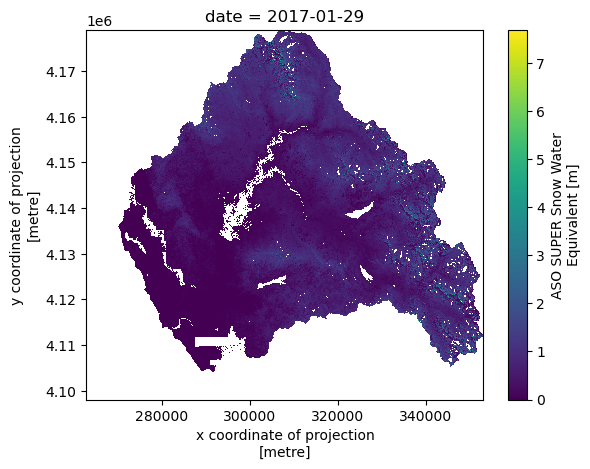

In [46]:
aso_data_1.aso_swe[0,:,:].plot()

### Plot 30 of 31 flights

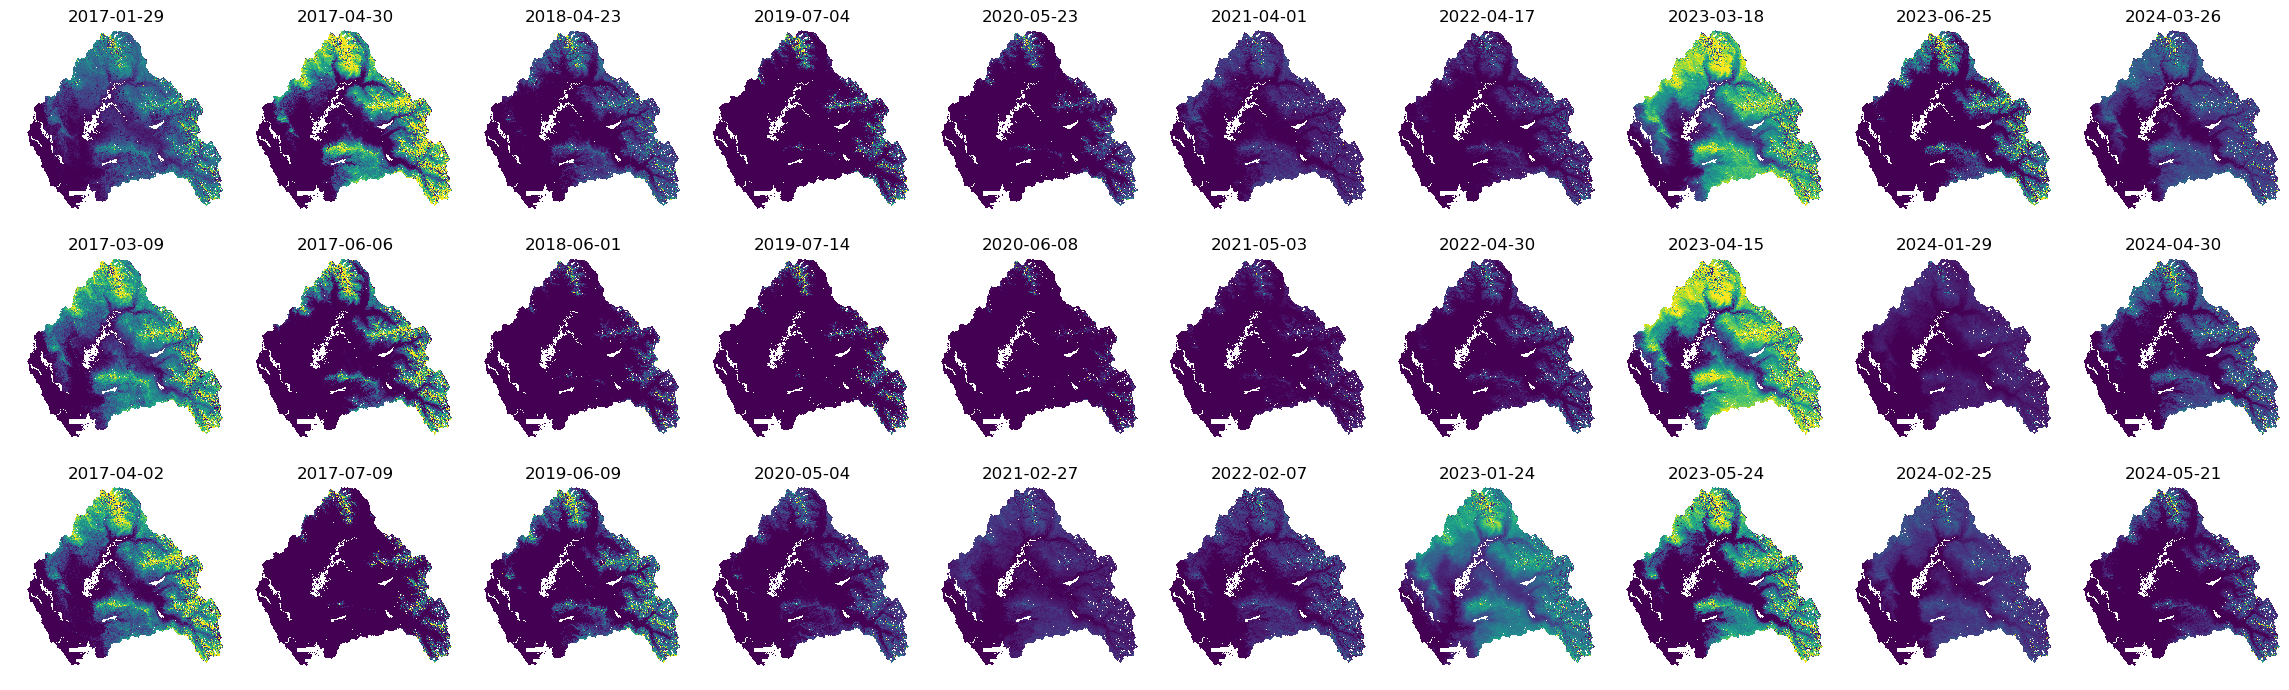

In [47]:
fig,ax = plt.subplots(3,10,figsize = (23,7))
for flight in range(0,aso_data_1.aso_swe.shape[0]):
    if flight <= 29: # because zero indexed
        aso_data_1.aso_swe[flight].plot(ax=ax[flight % 3,flight // 3],vmin = 0,vmax = 2.5,add_colorbar = False)
        ax[flight % 3,flight // 3].set_title(str(aso_data_1.date[flight].values)[0:10])
        ax[flight % 3,flight // 3].axis("off")
plt.tight_layout()
plt.show()